['Eta',
 'KPPhbl',
 'oceFWflx',
 'oceQnet',
 'oceQsw',
 'oceSflux',
 'oceTAUX oceTAUY',
 'PhiBot',
 'Salt',
 'SIarea',
 'SIheff',
 'SIhsalt',
 'SIhsnow',
 'SIuice SIvice',
 'Theta',
 'U V W']

In [1]:
import numpy as np
import xarray as xr
import xmitgcm.llcreader as llcreader
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#3D plot
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
## read in 3D data from public portal (you don't have to download!)
model = llcreader.ECCOPortalLLC2160Model()
ds = model.get_dataset(varnames=['Salt'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(4550,4750),i=slice(7550,7800),k=slice(0,90))
array2 = xr.DataArray(subset2.Salt.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
array2 = array2.load()

In [3]:
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest')
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
temp_new=np.linspace(down_lowest,up_lowest.data,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

In [4]:
data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
df = df.rename(columns={'getitem-9da8987598912d94d3ef2424c3afd049':'Salinity'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','Salinity', 'lat', 'lon']]
#del df['lat']
#del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_Salt.csv")
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_Salt_nolatlon.csv")
df_save = df

Text(4000, 36.1, 'Pause')

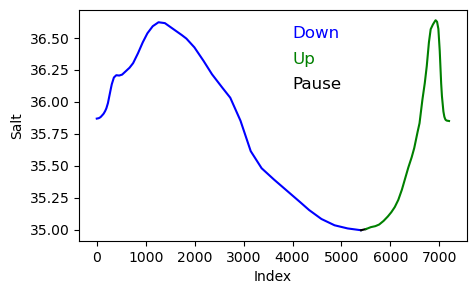

In [5]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(0,5400),down_data2.data,color='blue')
tem = middle_data
plt.plot(np.arange(0,101)+5400,tem,color='black')
tem = up_data2.isel(depth=slice(None, None, -1))
plt.plot(np.arange(0,1699)+5501,tem,color='green')
plt.ylabel('Salt')
plt.xlabel('Index')
plt.text(4000, 36.5, "Down", color="blue", fontsize=12)
plt.text(4000, 36.3, "Up", color="green", fontsize=12)
plt.text(4000, 36.1, "Pause", color="black", fontsize=12)

# now do temperature (theta)

In [6]:
ds = model.get_dataset(varnames=['Theta'], type='latlon')
subset2 = ds.isel(time=-1,j=slice(4550,4750),i=slice(7550,7800),k=slice(0,90))
array2 = xr.DataArray(subset2.Theta.data,dims=['depth','lat','lon'],coords={'depth':subset2.Z.data,'lat':subset2.YC[:,0].data,'lon':subset2.XC[0,:].data})
array2 = array2.load()

In [7]:
down_data = array2.sel(lat=25.6,lon= -79.48,method='nearest')
down_data["depth"] = down_data["depth"].astype(np.float32) #convert depth to float32
up_data = array2.sel(lat=25.6,lon=-79.81,method='nearest')
up_data["depth"] = up_data["depth"].astype(np.float32) #convert depth to float32

i1=0; i2=48;
tem = down_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,5400)
down_data2 = tem.interp(depth=depth_new)
down_lowest = down_data2[-1].data #save lowest value

i1=0; i2=47;
tem = up_data[i1:i2]
depth_new=np.linspace(tem.depth[0].data,tem.depth[-1].data,1699)
up_data2 = tem.interp(depth=depth_new)
up_lowest = up_data2[-1].data #save lowest value

i1=0; i2=101;
tem = down_data2[i1:i2].copy()
depth_new=np.linspace(down_data2.depth[-1].data,up_data2.depth[-1].data,101)
temp_new=np.linspace(down_lowest,up_lowest.data,101)
middle_data = tem
middle_data['depth']=depth_new #set depth all to deepest point
middle_data[:]=temp_new #set temp to lowest temp

In [8]:
data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
df = df.rename(columns={'getitem-be70884a9fcd6b8bb0d4bffa99fceec4':'Theta'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','Theta', 'lat', 'lon']]
#save data
df.to_csv("./data/data_bottom_pause_Theta.csv")
df

,depth,Theta,lat,lon
timestep,,,,
0,-0.500000,26.478880,25.601171,-79.479164
1,-0.650428,26.479834,25.601171,-79.479164
2,-0.800856,26.480785,25.601171,-79.479164
3,-0.951284,26.481739,25.601171,-79.479164
4,-1.101711,26.482691,25.601171,-79.479164
...,...,...,...,...
7195,-2.314099,26.714104,25.601171,-79.812500
7196,-1.860574,26.713129,25.601171,-79.812500
7197,-1.407049,26.711470,25.601171,-79.812500


In [9]:
data_bottom_pause = xr.concat(
    [down_data2,middle_data,up_data2.isel(depth=slice(None, None, -1))],
    dim='depth')
df = data_bottom_pause.to_dataframe()
df = df.rename(columns={'getitem-be70884a9fcd6b8bb0d4bffa99fceec4':'Theta'})
df['depth']=df.index
#df['timestep'] = np.arange(7200)
df.index=np.arange(7200)
df.index.name = 'timestep'
#df = df[['timestep', 'depth','Theta', 'lat', 'lon']]
df = df[['depth','Theta', 'lat', 'lon']]
del df['lat']
del df['lon']
#save data
df.to_csv("./data/data_bottom_pause_Theta_nolatlon.csv")
df

,depth,Theta
timestep,,
0,-0.500000,26.478880
1,-0.650428,26.479834
2,-0.800856,26.480785
3,-0.951284,26.481739
4,-1.101711,26.482691
...,...,...
7195,-2.314099,26.714104
7196,-1.860574,26.713129
7197,-1.407049,26.711470


Text(4000, 21, 'Pause')

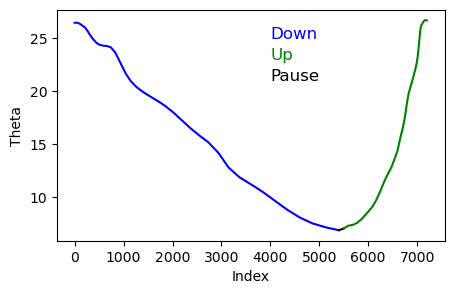

In [10]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(0,5400),down_data2.data,color='blue')
tem = middle_data
plt.plot(np.arange(0,101)+5400,tem,color='black')
tem = up_data2.isel(depth=slice(None, None, -1))
plt.plot(np.arange(0,1699)+5501,tem,color='green')
plt.ylabel('Theta')
plt.xlabel('Index')
plt.text(4000, 25, "Down", color="blue", fontsize=12)
plt.text(4000, 23, "Up", color="green", fontsize=12)
plt.text(4000, 21, "Pause", color="black", fontsize=12)

In [11]:
df_save['Theta'] = df['Theta']
df.to_csv("./data/data_bottom_pause_ThetaSalt_nolatlon.csv")

In [12]:
df

,depth,Theta
timestep,,
0,-0.500000,26.478880
1,-0.650428,26.479834
2,-0.800856,26.480785
3,-0.951284,26.481739
4,-1.101711,26.482691
...,...,...
7195,-2.314099,26.714104
7196,-1.860574,26.713129
7197,-1.407049,26.711470
